In [317]:
# 数据生成，还是得把写入文件，这样才方便读取
import numpy as np
import matplotlib.pyplot as plt
import copy

In [417]:
# 手动生成  中心点为0，0
center_point = [0,0]
point_gap = 1.0
pre_cuttoff = 3
ult_cuttoff = 3.0

In [418]:
x_ax = np.linspace(-5,5,11)
y_ax = np.linspace(-5,5,11)
# 创建一个空的NumPy数组 【原始的干净数组】
list_point = []

# 筛选数据
for i in x_ax:
    for j in y_ax:
        if i**2+j**2 < pre_cuttoff**2 and  (not(i== 0 and j== 0)):
            list_point.append([i,j])
list_point = np.array(list_point)

In [612]:
# 给这些点随机扰动
def get_rand(temp_list=[],min_val=-0.3,max_val=0.3):
    # 生成随机扰动矩阵
    return np.random.uniform(min_val, max_val, size=temp_list.shape)
# 生成正态分布扰动矩阵
def get_normal(temp_list=[],loc=0,scale=0.1):
    return np.random.normal(loc=loc, scale=scale, size=temp_list.shape)

# 生成一个画图程序
def draw_pic(list_temp=[], radius=3):
    plt.scatter(list_temp[:,0],list_temp[:,1])
    circle = Circle([0,0], radius, fill=False, color='red')
    plt.gca().add_patch(circle)
    plt.show()
# 定义旋转角度（以角度为单位）
def rotate_matrix(list_temp=[]):
    # 要对原始数据有操作的函数，必须加上深拷贝
    list_temp = copy.deepcopy(list_temp)
    angle_num =np.random.randint(361)
    angle = np.deg2rad(angle_num)  
    # 计算旋转矩阵
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    return np.dot(list_temp, rotation_matrix)

# 定义生成一次数据的函数
def get_once_data(list_temp=[],label=-1,val_1=-1,val_2=1):
    # 要对原始数据有操作的函数，必须加上深拷贝
    list_temp = copy.deepcopy(list_temp)
    # 规则数据
    if label==1:
        # 加噪声
        list_temp += get_normal(list_temp,val_1,val_2)
        # 再旋转
        return rotate_matrix(list_temp)
    # 不规则数据
    elif label==0:
        list_temp += get_rand(list_temp,val_1,val_2)
        list_temp = rotate_matrix(list_temp)
        return list_temp
    else:
        print('Label is ',label,' !')
        return -1

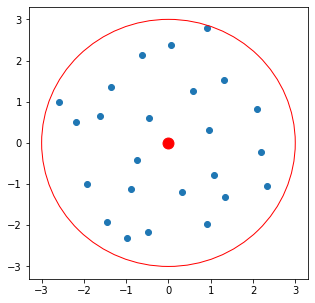

In [616]:
list_temp = copy.deepcopy(list_point)
list_temp += get_rand(list_point,-0.3,0.3)
list_temp = rotate_matrix(list_temp)
plt.figure(figsize=(5,5))
plt.scatter(0,0,c='r',s=120)
draw_pic(list_temp)

# 算了 先不要这部分 因为这可能造成它根据数据点来分类
def filter_data(temp_list,dis,count_data):
    num = 0
    for i in temp_list:
        if i[0]**2+i[1]**2>dis**2:
            num+=1
    

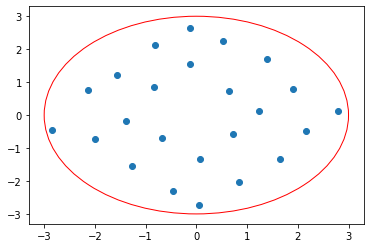

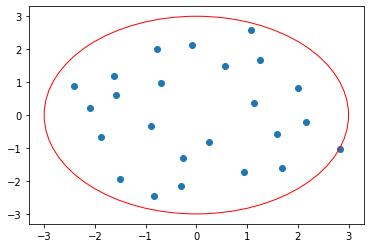

In [423]:
a = get_once_data(copy.deepcopy(list_point),label=1,val_1=0,val_2=0.1)
b = get_once_data(copy.deepcopy(list_point),label=0,val_1=-0.25,val_2=0.25)
print('')
draw_pic(a,3)
draw_pic(b,3)

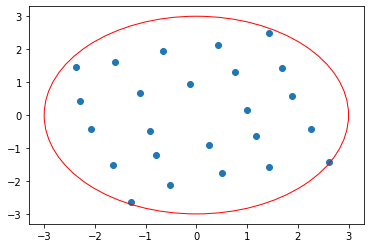

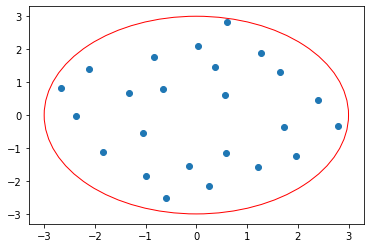

In [439]:
a = get_once_data(list_point,label=1,val_1=0,val_2=0.1)
b = get_once_data(list_point,label=0,val_1=-0.3,val_2=0.3)
draw_pic(a,3)
draw_pic(b,3)

In [675]:
# 数据量总数
train_dataNum = 10000
train_data = []
train_labels = []
for i in range(train_dataNum//2):
    train_data.append(get_once_data(list_point,1,0,0.1))
    train_labels.append(1)
for i in range(train_dataNum//2):
    train_data.append(get_once_data(list_point,0,-0.3,0.3))
    train_labels.append(0)
train_labels = np.array(train_labels).reshape(-1)

In [676]:
# 数据量总数
test_dataNum = 1000
test_data = []
test_labels = []
for i in range(test_dataNum//2):
    test_data.append(get_once_data(list_point,1,0,0.1))
    test_labels.append(1)
for i in range(test_dataNum//2):
    test_data.append(get_once_data(list_point,0,-0.3,0.3))
    test_labels.append(0)
    
test_labels = np.array(test_labels).reshape(-1)

In [677]:
# 打印形状
print(np.array(train_data).shape)
print(np.array(train_labels).shape)
# 打印形状
print(np.array(test_data).shape)
print(np.array(test_labels).shape)

(10000, 24, 2)
(10000,)
(1000, 24, 2)
(1000,)


# 建模

In [678]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [687]:
# 参数设置
batch_size = 124
num_epochs = 100

In [688]:
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        
        # MLP做局部特征提取
        self.mlp1 = nn.Sequential(
            nn.Conv1d(2, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # 提取全局特征
        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        # 全连接网络进行分类
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  
    
    def forward(self, x):
        # 对输入张量x进行维度排列操作，将通道维度放在第二个位置。
        x = x.permute(0, 2, 1)
        
        # 局部特征提取
        x = self.mlp1(x)
        
        # 最大池化操作，以获得全局特征。
        x = torch.max(x, dim=2)[0]
        
        # 特征提取
        x = self.mlp2(x.unsqueeze(2))
        
        # 再次进行最大池化操作，以获得最终的全局特征
        x = torch.max(x, dim=2)[0]
        
        # 分类层
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x


In [689]:
# 将数据转换为Tensor
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels).long()

# 创建数据集和数据加载器
dataset = torch.utils.data.TensorDataset(train_data, train_labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 将数据转换为Tensor
test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels).long()

# 创建测试数据集和数据加载器
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [690]:
# 创建PointNet模型实例
model = PointNet()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 准备数据集并进行训练
# 假设train_data是训练数据集，train_labels是对应的标签
list_loss = []
# 训练模型
for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    list_loss.append(loss)

In [691]:
list_loss_np_y = []
list_loss_x = []
for i in range(len(list_loss)):
    numpy_array = list_loss[i].detach().numpy()
    list_loss_np_y.append(numpy_array)
    list_loss_x.append(i)

Text(0.5, 1.0, 'Loss with epochs')

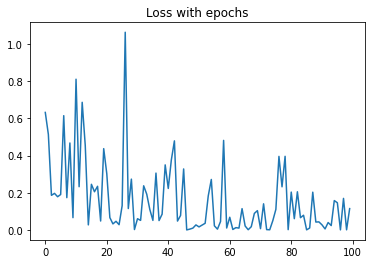

In [692]:
plt.plot(list_loss_x,list_loss_np_y)
plt.title('Loss with epochs')

In [693]:
# 在测试集上进行预测
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data, batch_labels in test_dataloader:
        outputs = model(batch_data)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    print('Accuracy on test set: {:.2%}'.format(accuracy))

Accuracy on test set: 93.90%
